In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model,models
from tensorflow.keras.layers import LeakyReLU
import tensorflow_addons as tfa


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
base_dir = 'ICCV2021Data/COV19DCompetition/Data/'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

In [3]:
# Directory with covid training images
train_covid_dir = os.path.join(train_dir,'covid')
#Directory with non-covid training images
train_non_covid_dir = os.path.join(train_dir,'non-covid')

In [4]:
# Directory with covid validation images
validation_covid_dir = os.path.join(validation_dir,'covid')
# Directory with non-covid validation images
validation_non_covid_dir = os.path.join(validation_dir, 'non-covid')

In [5]:
train_covid_fnames = os.listdir(train_covid_dir)
print(train_covid_fnames[:10])


['ct_scan_0_0.jpg', 'ct_scan_0_1.jpg', 'ct_scan_0_10.jpg', 'ct_scan_0_100.jpg', 'ct_scan_0_101.jpg', 'ct_scan_0_102.jpg', 'ct_scan_0_103.jpg', 'ct_scan_0_104.jpg', 'ct_scan_0_105.jpg', 'ct_scan_0_106.jpg']


In [6]:
train_non_covid_fnames = os.listdir(train_non_covid_dir)
print(train_non_covid_fnames[:10])

['ct_scan_0_0.jpg', 'ct_scan_0_1.jpg', 'ct_scan_0_10.jpg', 'ct_scan_0_100.jpg', 'ct_scan_0_101.jpg', 'ct_scan_0_102.jpg', 'ct_scan_0_103.jpg', 'ct_scan_0_104.jpg', 'ct_scan_0_105.jpg', 'ct_scan_0_106.jpg']


In [7]:
print('total number of training covid images:', len(os.listdir(train_covid_dir)))
print('total number of training non covid images:', len(os.listdir(train_non_covid_dir)))
print('total number of validation covid images:', len(os.listdir(validation_covid_dir)))
print('total number of validation non covid images:', len(os.listdir(validation_non_covid_dir)))

total number of training covid images: 153681
total number of training non covid images: 181991
total number of validation covid images: 35016
total number of validation non covid images: 40517


In [8]:
nrows = 4
ncols = 4

pic_index = 0

In [9]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows * 4)

pic_index += 8
next_covid_pix = [os.path.join(train_covid_dir, fname)
                 for fname in train_covid_fnames[pic_index-8:pic_index]]

next_non_covid_pix = [os.path.join(train_non_covid_dir, fname)
                 for fname in train_non_covid_fnames[pic_index-8:pic_index]]

<Figure size 1152x1152 with 0 Axes>

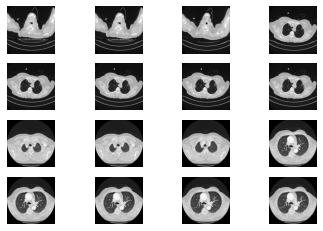

In [10]:
for i, img_path in enumerate(next_covid_pix + next_non_covid_pix):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img,cmap='gray')

plt.show()

In [14]:
def make_model():
    '''
    Define your model architecture here.
    Returns `Sequential model`
    '''
    
    model = models.Sequential()
    
    model.add(layers.Conv2D(64,(3,3),input_shape=(224,224,3),padding="same", activation="relu"))
    model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
    
#     model.add(layers.Conv2D(32,(3,3),activation = 'relu', padding="same"))

    model.add(layers.Conv2D(128,(3,3), padding="same",activation="relu"))
    model.add(layers.Conv2D(128,(3,3), padding="same",activation="relu"))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
              
    model.add(layers.Conv2D(256,(3,3), padding="same",activation="relu"))
    model.add(layers.Conv2D(256,(3,3), padding="same",activation="relu"))
    model.add(layers.Conv2D(256,(3,3), padding="same",activation="relu"))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(layers.Conv2D(512,(3,3), padding="same",activation="relu"))
    model.add(layers.Conv2D(512,(3,3), padding="same",activation="relu"))
    model.add(layers.Conv2D(512,(3,3), padding="same",activation="relu"))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
    
              
    model.add(layers.Conv2D(512,(3,3), padding="same",activation="relu"))
    model.add(layers.Conv2D(512,(3,3), padding="same",activation="relu"))
    model.add(layers.Conv2D(512,(3,3), padding="same",activation="relu"))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
    

    
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(4096,activation="relu"))
    model.add(layers.Dense(4096,activation="relu"))
    
      

    model.add(layers.Dense(1,activation='sigmoid'))
    
    
    
    return model

In [15]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [16]:
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(learning_rate=0.0001),
             metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(224,224),
            batch_size=32,
            class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
            validation_dir,
            target_size =(224,224),
            batch_size=32,
            class_mode='binary')

Found 335672 images belonging to 2 classes.
Found 75534 images belonging to 2 classes.


## Learning rate scheduler

In [18]:
INIT_LR = 1e-4

In [19]:
# learning rate fraction
lr_frac = 0.7
def lr_scheduler(epoch):
        return INIT_LR * lr_frac ** epoch
# callback for printing of actual learning rate used by optimizer
class LrHistory(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        tf.print(("Learning rate:",model.optimizer.lr))
   

In [22]:
history= model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=10,
    verbose=2,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler),LrHistory()]
    )

Epoch 1/10
('Learning rate:', 0.0001)
100/100 - 4702s - loss: 0.7152 - precision: 0.5354 - recall: 0.9901 - val_loss: 0.6890 - val_precision: 0.5437 - val_recall: 1.0000
Epoch 2/10
('Learning rate:', 7e-05)
100/100 - 2825s - loss: 0.6740 - precision: 0.5937 - recall: 0.7356 - val_loss: 0.6161 - val_precision: 0.7568 - val_recall: 0.6222
Epoch 3/10
('Learning rate:', 4.9e-05)
100/100 - 2796s - loss: 0.6570 - precision: 0.6696 - recall: 0.6435 - val_loss: 0.6438 - val_precision: 0.6570 - val_recall: 0.6766
Epoch 4/10
('Learning rate:', 3.43e-05)
100/100 - 2845s - loss: 0.6400 - precision: 0.6768 - recall: 0.6779 - val_loss: 0.5901 - val_precision: 0.7018 - val_recall: 0.8377
Epoch 5/10
('Learning rate:', 2.401e-05)
100/100 - 2870s - loss: 0.6207 - precision: 0.6892 - recall: 0.7178 - val_loss: 0.6950 - val_precision: 0.5737 - val_recall: 0.8944
Epoch 6/10
('Learning rate:', 1.6807e-05)
100/100 - 3456s - loss: 0.6089 - precision: 0.6973 - recall: 0.7185 - val_loss: 0.5895 - val_precision:

In [23]:
val_precision = history.history['val_precision']
avg_precision = np.mean(val_precision)
avg_precision

0.6577396988868713

In [24]:
val_recall = history.history['val_recall']
avg_recall = np.mean(val_recall)
avg_recall

0.8003910958766938

In [25]:
F1score = (2*avg_precision*avg_recall)/ (avg_precision + avg_recall)
F1score

0.7220874838995948

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [27]:
epochs = range(len(loss))

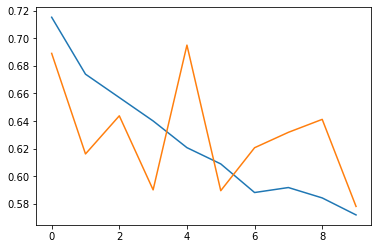

In [28]:
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)